<a href="https://colab.research.google.com/github/ohnownihs/NLP/blob/master/Learning_Spoons_5%EA%B0%95_(%EA%B0%9C%EC%B2%B4%EB%AA%85_%EC%9D%B8%EC%8B%9D)_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 양방향 LSTM을 이용한 영어 품사 태깅

## 데이터 로드하기

In [ ]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [ ]:
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


## 데이터와 레이블 분리하기

품사 태깅 전처리가 수행된 첫번째 문장이 출력된 것을 볼 수 있습니다. 이러한 문장 샘플이 총 3,914개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('Pierre', 'NNP'), ('Vinken', 'NNP')]와 같은 문장 샘플이 있다면 Pierre과 Vinken을 같이 저장하고, NNP와 NNP를 같이 저장할 필요가 있습니다.

이런 경우 파이썬 함수 중에서 zip()함수가 유용한 역할을 합니다. zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다.

In [ ]:
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


In [ ]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


## 단어 집합 만들기 (데이터와 레이블)

In [ ]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [ ]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


## 정수 인코딩 (데이터와 레이블)

In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [ ]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


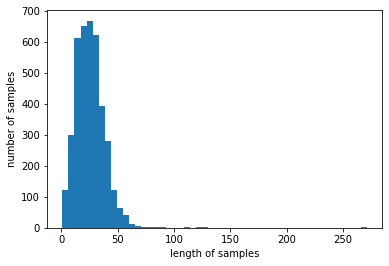

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, X_train))/len(X_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


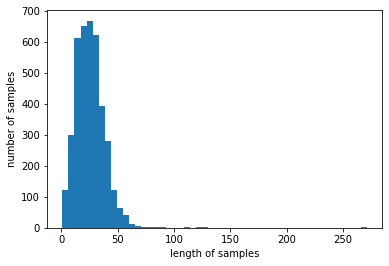

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in y_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, y_train))/len(y_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 패딩(Padding)

In [ ]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen = max_len)
y_train = pad_sequences(y_train, padding='post', maxlen = max_len)

## 훈련 데이터와 테스트 데이터 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

## 레이블에 대한 원-핫 인코딩

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


## 양방향 LSTM으로 시퀀스 레이블링하기

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=6,  validation_data=(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3131 samples, validate on 783 samples
Epoch 1/6
3131/3131 [==============================] - 28s 9ms/step - loss: 0.5777 - accuracy: 0.1375 - val_loss: 0.5089 - val_accuracy: 0.1468
Epoch 2/6
3131/3131 [==============================] - 25s 8ms/step - loss: 0.4922 - accuracy: 0.2294 - val_loss: 0.4603 - val_accuracy: 0.3389
Epoch 3/6
3131/3131 [==============================] - 25s 8ms/step - loss: 0.4032 - accuracy: 0.4385 - val_loss: 0.3183 - val_accuracy: 0.5062
Epoch 4/6
3131/3131 [==============================] - 25s 8ms/step - loss: 0.2511 - accuracy: 0.6189 - val_loss: 0.1848 - val_accuracy: 0.7334
Epoch 5/6
3131/3131 [==============================] - 25s 8ms/step - loss: 0.1322 - accuracy: 0.8307 - val_loss: 0.1010 - val_accuracy: 0.8651
Epoch 6/6
3131/3131 [==============================] - 25s 8ms/step - loss: 0.0676 - accuracy: 0.9155 - val_loss: 0.0669 - val_accuracy: 0.9043


## 테스트 데이터에 대한 평가

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

783/783 [==============================] - 3s 4ms/step

 테스트 정확도: 0.9043


In [ ]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .


# 양방향 LSTM을 이용한 영어 개체명 인식

## 데이터 로드하기

In [ ]:
import urllib.request
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt", filename="train.txt")

('train.txt', <http.client.HTTPMessage at 0x7f2795590c18>)

## 데이터 살펴보기 

In [ ]:
f = open('train.txt', 'r')

In [ ]:
# 불필요한 줄은 출력하지 않되, 데이터에서 12번째 줄까지 출력 
i = 0
for line in f:
  if len(line) == 0 or line.startswith('-DOCSTART'):
    continue
  i = i + 1
  if i == 1:
    continue
  print(line, end='')
  if i == 13:
    break

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER


  데이터의 형식은 [단어] [품사 태깅] [청크 태깅] [개체명 태깅]의 형식으로 되어있습니다.  

품사 태깅이 의미하는 바는 아래 링크에서 자세하게 확인할 수 있는데, 예를 들어서 EU 옆에 붙어있는 NNP는 고유 명사 단수형을 의미하며, rejects 옆에 있는 VBZ는 3인칭 단수 동사 현재형을 의미합니다. (사실 이번 실습에서 중요하지는 않습니다.)
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html  

 개체명 태깅의 경우에는 LOC는 location, ORG는 organization, PER은 person, MISC는 miscellaneous를 의미합니다. 해당 데이터는 BIO 표현 방법을 사용하고 있기 때문에, 개체명의 시작 부분이면서 Organization을 의미하는 German에는 B-ORG라는 개체명 태깅이 붙습니다. 다만, German 그 자체로 개체명 하나이기 때문에 거기서 개체명 인식은 종료되면서 뒤에 I가 별도로 붙는 단어가 나오지는 않았습니다. 이에 German 뒤에 나오는 call은 개체명이 아니기 때문에 O가 태깅이 됩니다.  

 또 하나 기억해두어야할 것은. . O O 다음에 11번째 줄 Peter가 나오는 부분 사이에서 줄바꿈이 한 번 더 되어 있는데, 새로운 문장이 시작됨을 의미합니다.  

 새로운 문장에서는 개체명이 하나의 단어로 끝나지 않았을 때, 어떻게 다음 단어로 개체명 인식이 이어지는지를 보여줍니다. Peter는 개체명이 시작되면서 person에 해당되기 때문에 B-PER이라는 개체명 태깅이 붙습니다. 그리고 아직 개체명에 대한 인식은 끝나지 않았으므로 뒤에 붙는 Blackburn에서는 I가 나오면서 I-PER이 개체명 태깅으로 붙습니다. 즉, Peter Blackburn이 person이라는 하나의 개체명입니다.  

## 간단한 전처리 후 샘플 저장하기

In [ ]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [ ]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14041


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


## 데이터와 레이블 분리하기

전처리가 수행된 첫번째 샘플이 출력된 것을 볼 수 있습니다. 이러한 샘플이 총 14,041개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('eu', 'B-ORG'), ('rejects', 'O')]와 같은 문장 샘플이 있다면 eu와 rejects는 같이 저장하고, B-ORG와 O를 같이 저장할 필요가 있습니다.

이런 경우 파이썬 함수 중에서 zip()함수가 유용한 역할을 합니다. zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다.

In [ ]:
# 데이터와 레이블 분리
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서만 sentences[0]에, 또한 개체명에 대해서만 ner_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 ner_tags는 예측 대상인 y에 해당됩니다. 다른 샘플들에 대해서도 처리가 되었는지 확인하기 위해 임의로 13번째 샘플에 대해서도 확인해보겠습니다.

In [ ]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


## 단어 집합 만들기 (데이터와 레이블)

In [ ]:
# 개체명 인식 데이터에 대해서 최대 단어수는 4,000개로 제한.
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

In [ ]:
# 레이블 데이터 또한 시퀀스 데이터므로 똑같이 각 토큰에 고유한 정수 부여.
# 레이블의 단어 집합을 만든다.
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = max_words + 2
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4002
개체명 태깅 정보 집합의 크기 : 10


## 정수 인코딩 (데이터와 레이블)

In [ ]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [ ]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [ ]:
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


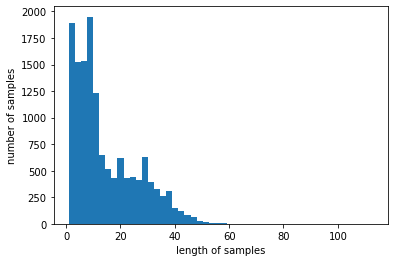

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, X_train))/len(X_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 패딩(Padding)

In [ ]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.

샘플의 최대 길이 : 70
샘플의 평균 길이 : 70.000000


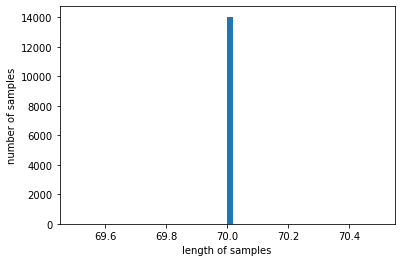

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, X_train))/len(X_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터와 테스트 데이터 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

## 레이블에 대한 원-핫 인코딩

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


## 양방향 LSTM으로 시퀀스 레이블링하기

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(tag_size, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size = 256, epochs = 10,  validation_data=(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11232 samples, validate on 2809 samples
Epoch 1/10
11232/11232 [==============================] - 15s 1ms/step - loss: 0.2241 - accuracy: 0.8160 - val_loss: 0.1544 - val_accuracy: 0.8331
Epoch 2/10
11232/11232 [==============================] - 14s 1ms/step - loss: 0.1446 - accuracy: 0.8321 - val_loss: 0.1200 - val_accuracy: 0.8339
Epoch 3/10
11232/11232 [==============================] - 14s 1ms/step - loss: 0.1040 - accuracy: 0.8463 - val_loss: 0.0875 - val_accuracy: 0.8670
Epoch 4/10
11232/11232 [==============================] - 14s 1ms/step - loss: 0.0799 - accuracy: 0.8808 - val_loss: 0.0687 - val_accuracy: 0.8972
Epoch 5/10
11232/11232 [==============================] - 14s 1ms/step - loss: 0.0626 - accuracy: 0.9091 - val_loss: 0.0538 - val_accuracy: 0.9223
Epoch 6/10
11232/11232 [==============================] - 14s 1ms/step - loss: 0.0489 - accuracy: 0.9299 - val_loss: 0.0438 - val_accuracy: 0.9383
Epoch 7/10
11232/11232 [==============================] - 14s 1ms/ste

## 테스트 데이터에 대한 평가

In [ ]:
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
pre

# 양방향LSTM-CNN을 이용한 한국어 개체명 인식

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 67.1MB/s 
     |████████████████████████████████| 3.6MB 61.0MB/s 
     |████████████████████████████████| 92kB 11.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
def createBatches(data):
    l = []
    for i in data:
        l.append(len(i[0]))
    l = set(l)
    batches = []
    batch_len = []
    z = 0
    for i in l:
        for batch in data:
            if len(batch[0]) == i:
                batches.append(batch)
                z += 1
        batch_len.append(z)
    return batches,batch_len

def iterate_minibatches(dataset,batch_len): 
    start = 0
    for i in batch_len:
        tokens = []
        char = []
        labels = []
        data = dataset[start:i]
        start = i
        for dt in data:
            t,ch,l = dt
            l = np.expand_dims(l,-1)
            tokens.append(t)
            char.append(ch)
            labels.append(l)
        yield np.asarray(labels),np.asarray(tokens),np.asarray(char)

In [ ]:
okt = Okt()

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/elymas/ai_chatbot_class/master/07_chatbot_class/tuto07(Intent%2C%20Entity)/Entity/train_entity.csv", filename="train_entity.csv")

('train_entity.csv', <http.client.HTTPMessage at 0x7fc1f25a4c18>)

In [ ]:
f = open('train_entity.csv', encoding='euc-kr')

In [ ]:
# 불필요한 줄은 출력하지 않되, 데이터에서 11번째 줄까지 출력 
i = 0
for line in f:
  if len(line) == 0 or line.startswith('-DOCSTART'):
    continue
  i = i + 1
  print(line, end='')
  if i == 11:
    break

다음 DATE
주 DATE
전주 LOCATION
비 O
오려나 O

이번 DATE
주 DATE
서울 LOCATION
눈 O
오니 O


데이터가 이미 토큰화되어 제공되고 있으나, 한국어의 경우 단순 띄어쓰기 기준으로 토큰화를 하는 것이 아니라 형태소 분석기에 따라서 토큰화 결과가 다르므로 사용하고자 하는 형태소 분석기에 맞게 재토큰화를 해보겠습니다.

In [ ]:
with open('train_entity.csv', encoding='euc-kr') as f:
    tokenized_sentences, labels = [], []
    tokenized_sentence, label = [], []
    for line in f:
        line = line.strip()
        if (len(line) == 0 or line.startswith("-DOCSTART-")):
            if not len(tokenized_sentence) == 0:
                tokenized_sentences.append(tokenized_sentence)
                labels.append(label)
                tokenized_sentence, label = [], [] #초기화
        else:
            word, tag = line.split(' ')
            tokenized_sentence.append(word)
            label.append(tag)

In [ ]:
tokenized_sentences[:5]

[['다음', '주', '전주', '비', '오려나'],
 ['이번', '주', '서울', '눈', '오니'],
 ['이번', '주', '대구', '날씨', '비', '오는지', '알려줘'],
 ['부산', '이번', '주', '날씨', '맑은지', '알려줄래'],
 ['광주', '이번', '주', '눈', '오려나']]

In [ ]:
labels[:5]

[['DATE', 'DATE', 'LOCATION', 'O', 'O'],
 ['DATE', 'DATE', 'LOCATION', 'O', 'O'],
 ['DATE', 'DATE', 'LOCATION', 'O', 'O', 'O', 'O'],
 ['LOCATION', 'DATE', 'DATE', 'O', 'O', 'O'],
 ['LOCATION', 'DATE', 'DATE', 'O', 'O']]

In [ ]:
for ts, label in zip(tokenized_sentences, labels):
    for idx, word in enumerate(ts):
        if len(okt.morphs(word))>1:
            tokenized_word = okt.morphs(word)
            ts.pop(idx)
            tag = label.pop(idx)
            for i in tokenized_word[::-1]:
                ts.insert(idx, i)
                label.insert(idx, tag)

In [ ]:
tokenized_sentences[:5]

[['다음', '주', '전주', '비', '오려나'],
 ['이번', '주', '서울', '눈', '오니'],
 ['이번', '주', '대구', '날씨', '비', '오는지', '알려줘'],
 ['부산', '이번', '주', '날씨', '맑은', '지', '알려줄래'],
 ['광주', '이번', '주', '눈', '오려나']]

In [ ]:
labels[:5]

[['DATE', 'DATE', 'LOCATION', 'O', 'O'],
 ['DATE', 'DATE', 'LOCATION', 'O', 'O'],
 ['DATE', 'DATE', 'LOCATION', 'O', 'O', 'O', 'O'],
 ['LOCATION', 'DATE', 'DATE', 'O', 'O', 'O', 'O'],
 ['LOCATION', 'DATE', 'DATE', 'O', 'O']]

In [ ]:
print('샘플 수 :',len(tokenized_sentences))
print('레이블 수 :',len(labels))

샘플 수 : 3851
레이블 수 : 3851


In [ ]:
frequency_cnt_set = Counter(sum(tokenized_sentences, []))

In [ ]:
print(frequency_cnt_set)

Counter({'날씨': 1757, '우산': 985, '하니': 825, '내일': 744, '오늘': 664, '써야': 590, '주': 553, '알려줘': 481, '이번': 473, '모레': 438, '말': 418, '알려줄래': 351, '마스크': 295, '비': 269, '챙길까': 240, '해줘': 172, '해주세요': 170, '울산': 168, '옷': 160, '입을까': 160, '우비': 160, '입어야': 160, '상태': 158, '전주': 156, '서울': 145, '쓸까': 145, '써야해': 140, '부산': 138, '광주': 138, '어떠니': 132, '뭐': 128, '야': 128, '공기': 126, '눈': 114, '오니': 110, '전북': 108, '지': 103, '좀': 92, '인천': 90, '군산': 90, '좋니': 86, '쓰기': 85, '고민': 85, '내': 84, '일': 84, '다음': 80, '말까': 80, '돼': 80, '챙겨야': 80, '어때': 72, '이천': 70, '오려나': 69, '뭔': 68, '맑니': 66, '알고있니': 66, '양주': 62, '해줄래': 60, '대구': 58, '알려주라': 57, '바람': 57, '하늘': 54, '강릉': 52, '오산': 50, '경상북도': 50, '알려주세요': 49, '강원도': 48, '마포구': 46, '싫은데': 45, '오는지': 44, '알려줄': 40, '수': 40, '알려': 40, '줘': 40, '싫어': 40, '알려줘요': 40, '있니': 38, '서산': 36, '맑은': 35, '맑아': 34, '전라북도': 34, '전라남도': 34, '서울시': 34, '강원': 34, '충청남도': 34, '충남': 34, '어떤지': 34, '알': 34, '아': 34, '미세먼지': 34, '경기도': 30, '전남': 30, '경남': 30, '경상남도': 3

In [ ]:
frequency_cnt_set = frequency_cnt_set.most_common() # 빈도순으로 정렬 + 리스트로 형변환
print(frequency_cnt_set)

[('날씨', 1757), ('우산', 985), ('하니', 825), ('내일', 744), ('오늘', 664), ('써야', 590), ('주', 553), ('알려줘', 481), ('이번', 473), ('모레', 438), ('말', 418), ('알려줄래', 351), ('마스크', 295), ('비', 269), ('챙길까', 240), ('해줘', 172), ('해주세요', 170), ('울산', 168), ('옷', 160), ('입을까', 160), ('우비', 160), ('입어야', 160), ('상태', 158), ('전주', 156), ('서울', 145), ('쓸까', 145), ('써야해', 140), ('부산', 138), ('광주', 138), ('어떠니', 132), ('뭐', 128), ('야', 128), ('공기', 126), ('눈', 114), ('오니', 110), ('전북', 108), ('지', 103), ('좀', 92), ('인천', 90), ('군산', 90), ('좋니', 86), ('쓰기', 85), ('고민', 85), ('내', 84), ('일', 84), ('다음', 80), ('말까', 80), ('돼', 80), ('챙겨야', 80), ('어때', 72), ('이천', 70), ('오려나', 69), ('뭔', 68), ('맑니', 66), ('알고있니', 66), ('양주', 62), ('해줄래', 60), ('대구', 58), ('알려주라', 57), ('바람', 57), ('하늘', 54), ('강릉', 52), ('오산', 50), ('경상북도', 50), ('알려주세요', 49), ('강원도', 48), ('마포구', 46), ('싫은데', 45), ('오는지', 44), ('알려줄', 40), ('수', 40), ('알려', 40), ('줘', 40), ('싫어', 40), ('알려줘요', 40), ('있니', 38), ('서산', 36), ('맑은', 35), ('맑아', 34)

In [ ]:
word_to_index = {}
i = 1
for (word, frequency) in frequency_cnt_set :
    i = i + 1
    word_to_index[word] = i
print(word_to_index)

{'날씨': 2, '우산': 3, '하니': 4, '내일': 5, '오늘': 6, '써야': 7, '주': 8, '알려줘': 9, '이번': 10, '모레': 11, '말': 12, '알려줄래': 13, '마스크': 14, '비': 15, '챙길까': 16, '해줘': 17, '해주세요': 18, '울산': 19, '옷': 20, '입을까': 21, '우비': 22, '입어야': 23, '상태': 24, '전주': 25, '서울': 26, '쓸까': 27, '써야해': 28, '부산': 29, '광주': 30, '어떠니': 31, '뭐': 32, '야': 33, '공기': 34, '눈': 35, '오니': 36, '전북': 37, '지': 38, '좀': 39, '인천': 40, '군산': 41, '좋니': 42, '쓰기': 43, '고민': 44, '내': 45, '일': 46, '다음': 47, '말까': 48, '돼': 49, '챙겨야': 50, '어때': 51, '이천': 52, '오려나': 53, '뭔': 54, '맑니': 55, '알고있니': 56, '양주': 57, '해줄래': 58, '대구': 59, '알려주라': 60, '바람': 61, '하늘': 62, '강릉': 63, '오산': 64, '경상북도': 65, '알려주세요': 66, '강원도': 67, '마포구': 68, '싫은데': 69, '오는지': 70, '알려줄': 71, '수': 72, '알려': 73, '줘': 74, '싫어': 75, '알려줘요': 76, '있니': 77, '서산': 78, '맑은': 79, '맑아': 80, '전라북도': 81, '전라남도': 82, '서울시': 83, '강원': 84, '충청남도': 85, '충남': 86, '어떤지': 87, '알': 88, '아': 89, '미세먼지': 90, '경기도': 91, '전남': 92, '경남': 93, '경상남도': 94, '속초': 95, '공주': 96, '과천': 97, '안양': 98, '완주': 99, '

In [ ]:
char_to_index = {'UNK' : 1}
for word in word_to_index:
  for char in word:
    if char not in char_to_index:
      char_to_index[char] = len(char_to_index) + 1

In [ ]:
print(char_to_index)

{'UNK': 1, '날': 2, '씨': 3, '우': 4, '산': 5, '하': 6, '니': 7, '내': 8, '일': 9, '오': 10, '늘': 11, '써': 12, '야': 13, '주': 14, '알': 15, '려': 16, '줘': 17, '이': 18, '번': 19, '모': 20, '레': 21, '말': 22, '줄': 23, '래': 24, '마': 25, '스': 26, '크': 27, '비': 28, '챙': 29, '길': 30, '까': 31, '해': 32, '세': 33, '요': 34, '울': 35, '옷': 36, '입': 37, '을': 38, '어': 39, '상': 40, '태': 41, '전': 42, '서': 43, '쓸': 44, '부': 45, '광': 46, '떠': 47, '뭐': 48, '공': 49, '기': 50, '눈': 51, '북': 52, '지': 53, '좀': 54, '인': 55, '천': 56, '군': 57, '좋': 58, '쓰': 59, '고': 60, '민': 61, '다': 62, '음': 63, '돼': 64, '겨': 65, '때': 66, '나': 67, '뭔': 68, '맑': 69, '있': 70, '양': 71, '대': 72, '구': 73, '라': 74, '바': 75, '람': 76, '강': 77, '릉': 78, '경': 79, '도': 80, '원': 81, '포': 82, '싫': 83, '은': 84, '데': 85, '는': 86, '수': 87, '아': 88, '남': 89, '시': 90, '충': 91, '청': 92, '떤': 93, '미': 94, '먼': 95, '속': 96, '초': 97, '과': 98, '안': 99, '완': 100, '불': 101, '삼': 102, '례': 103, '동': 104, '신': 105, '촌': 106, '종': 107, '로': 108, '여': 109, '의': 110, '창': 

In [ ]:
word_to_index['UNK'] = 1
print(word_to_index)

{'날씨': 2, '우산': 3, '하니': 4, '내일': 5, '오늘': 6, '써야': 7, '주': 8, '알려줘': 9, '이번': 10, '모레': 11, '말': 12, '알려줄래': 13, '마스크': 14, '비': 15, '챙길까': 16, '해줘': 17, '해주세요': 18, '울산': 19, '옷': 20, '입을까': 21, '우비': 22, '입어야': 23, '상태': 24, '전주': 25, '서울': 26, '쓸까': 27, '써야해': 28, '부산': 29, '광주': 30, '어떠니': 31, '뭐': 32, '야': 33, '공기': 34, '눈': 35, '오니': 36, '전북': 37, '지': 38, '좀': 39, '인천': 40, '군산': 41, '좋니': 42, '쓰기': 43, '고민': 44, '내': 45, '일': 46, '다음': 47, '말까': 48, '돼': 49, '챙겨야': 50, '어때': 51, '이천': 52, '오려나': 53, '뭔': 54, '맑니': 55, '알고있니': 56, '양주': 57, '해줄래': 58, '대구': 59, '알려주라': 60, '바람': 61, '하늘': 62, '강릉': 63, '오산': 64, '경상북도': 65, '알려주세요': 66, '강원도': 67, '마포구': 68, '싫은데': 69, '오는지': 70, '알려줄': 71, '수': 72, '알려': 73, '줘': 74, '싫어': 75, '알려줘요': 76, '있니': 77, '서산': 78, '맑은': 79, '맑아': 80, '전라북도': 81, '전라남도': 82, '서울시': 83, '강원': 84, '충청남도': 85, '충남': 86, '어떤지': 87, '알': 88, '아': 89, '미세먼지': 90, '경기도': 91, '전남': 92, '경남': 93, '경상남도': 94, '속초': 95, '공주': 96, '과천': 97, '안양': 98, '완주': 99, '

In [ ]:
print(len(char_to_index))
print(len(word_to_index))

223
532


In [ ]:
label_to_index = {}
index_to_label = []
for sample in labels:
    for label in sample:
        if label not in label_to_index:
            label_to_index[label] = len(label_to_index)
            index_to_label.append(label)

In [ ]:
print(label_to_index)

{'DATE': 0, 'LOCATION': 1, 'O': 2}


In [ ]:
print(index_to_label)

['DATE', 'LOCATION', 'O']


In [ ]:
MAX_LENGTH = 15

def padding_char_indice(char_indice, MAX_LENGTH):
    return pad_sequences(
      char_indice, maxlen=MAX_LENGTH, padding='post', 
      value = 0)
    
def integer_coding(tokenized_sentences, labels):
    dataset = []
    for ts, label in zip(tokenized_sentences, labels):
        word_indice = [word_to_index[t] for t in ts]
        char_indice = [[char_to_index[char] for char in t]  
                                                     for t in ts]
        char_indice = padding_char_indice(char_indice, MAX_LENGTH)
        label_indice = [label_to_index[l] for l in label]
    
        for chars_of_token in char_indice:
            if len(chars_of_token) > MAX_LENGTH:
                print("최대 단어 길이 초과!")
                continue
        dataset.append([word_indice, char_indice, label_indice])
    return dataset

In [ ]:
dataset = integer_coding(tokenized_sentences, labels)

In [ ]:
word_indice, char_indice, label_indice = dataset[0]

In [ ]:
word_indice

[47, 8, 25, 15, 53]

In [ ]:
index_to_word={}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [ ]:
print(' '.join([index_to_word[index] for index in word_indice]))

다음 주 전주 비 오려나


In [ ]:
label_indice

[0, 0, 1, 2, 2]

In [ ]:
char_indice

array([[62, 63,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [42, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [28,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10, 16, 67,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

In [ ]:
train_batch, train_batch_len = createBatches(dataset)

In [ ]:
for i, batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
        labels, tokens ,char = batch
        print(labels.shape, tokens.shape, char.shape)

(86, 2, 1) (86, 2) (86, 2, 15)
(637, 3, 1) (637, 3) (637, 3, 15)
(1043, 4, 1) (1043, 4) (1043, 4, 15)
(1509, 5, 1) (1509, 5) (1509, 5, 15)
(399, 6, 1) (399, 6) (399, 6, 15)
(157, 7, 1) (157, 7) (157, 7, 15)
(14, 8, 1) (14, 8) (14, 8, 15)
(4, 9, 1) (4, 9) (4, 9, 15)
(2, 24, 1) (2, 24) (2, 24, 15)


문장의 길이가 같으면 병렬 연산이 가능해진다. 이것이 단어 시퀀스에서 Padding을 하는 이유였다. 그렇다면 위에서는 병렬 연산을 위해 어떤 기준으로 묶인 것일까?  
Hint : 위 Shape에서 가운데 차원은 문장 길이다. 

In [ ]:
from tensorflow.keras.layers import Embedding, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.utils import Progbar

In [ ]:
# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim = len(word_to_index) + 1, output_dim = 64)(words_input)

# char 임베딩
character_input=Input(shape=(None,MAX_LENGTH,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(char_to_index)+1, 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout= Dropout(0.5)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(MAX_LENGTH))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)

# 출력층
output = TimeDistributed(Dense(len(label_to_index), activation='softmax'))(output)

model = Model(inputs=[words_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 15, 30) 6720        char_input[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 15, 30) 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 15, 30) 2730        dropout[0][0]                    
______________________________________________________________________________________________

char embedding params : 224 * 30 = 6720  
word embedding params : 533 * 64 = 34112  
Cov1d : 30 * 3 * 30 + 30 = 2730



In [ ]:
epochs = 20

for epoch in range(epochs):    
    print("Epoch %d/%d"%(epoch,epochs))
    a = Progbar(len(train_batch_len))
    for i,batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
        labels, tokens, char = batch       
        model.train_on_batch([tokens, char], labels)
        a.update(i)
    a.update(i+1)
    print(' ')

Epoch 0/20
9/9 [==============================] - 36s 4s/step
 
Epoch 1/20
9/9 [==============================] - 0s 43ms/step
 
Epoch 2/20
9/9 [==============================] - 0s 38ms/step
 
Epoch 3/20
9/9 [==============================] - 0s 39ms/step
 
Epoch 4/20
9/9 [==============================] - 0s 37ms/step
 
Epoch 5/20
9/9 [==============================] - 0s 39ms/step
 
Epoch 6/20
9/9 [==============================] - 0s 41ms/step
 
Epoch 7/20
9/9 [==============================] - 0s 36ms/step
 
Epoch 8/20
9/9 [==============================] - 0s 38ms/step
 
Epoch 9/20
9/9 [==============================] - 0s 37ms/step
 
Epoch 10/20
9/9 [==============================] - 0s 37ms/step
 
Epoch 11/20
9/9 [==============================] - 0s 38ms/step
 
Epoch 12/20
9/9 [==============================] - 1s 73ms/step
 
Epoch 13/20
9/9 [==============================] - 0s 37ms/step
 
Epoch 14/20
9/9 [==============================] - 0s 38ms/step
 
Epoch 15/20
9/9 [====

In [ ]:
prediction = '내일 부산 날씨는?'

In [ ]:
tokens = okt.morphs(prediction)
print(tokens)

['내일', '부산', '날씨', '는', '?']


In [ ]:
word_and_chars = [[word, list(str(word))] for word in tokens]
print(word_and_chars)

[['내일', ['내', '일']], ['부산', ['부', '산']], ['날씨', ['날', '씨']], ['는', ['는']], ['?', ['?']]]


In [ ]:
wordIndices = []    
charIndices = []

for word, chars in word_and_chars:
  if word in word_to_index:
    wordIndices.append(word_to_index[word])
  else:
    wordIndices.append(word_to_index['UNK'])
  temp = []
  for char in chars:
      if char in char_to_index:
        temp.append(char_to_index[char])
      else:
        temp.append(char_to_index['UNK'])
  charIndices.append(temp)

print(wordIndices)
print(charIndices)

[5, 29, 2, 1, 1]
[[8, 9], [45, 5], [2, 3], [86], [1]]


In [ ]:
charIndices = pad_sequences(charIndices, maxlen=MAX_LENGTH, padding='post', value = 0)

In [ ]:
print(wordIndices)
print(charIndices)

[5, 29, 2, 1, 1]
[[ 8  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [45  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [86  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [ ]:
wordIndices = np.asarray([wordIndices])     
charIndices = np.asarray([charIndices])

In [ ]:
print(wordIndices)
print(charIndices)

[[ 5 29  2  1  1]]
[[[ 8  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
  [45  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
  [ 2  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
  [86  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]]


In [ ]:
y_predicted = model.predict([wordIndices, charIndices], verbose=False)[0]

In [ ]:
print(y_predicted)

[[9.93093491e-01 6.71002269e-03 1.96557507e-04]
 [4.51007811e-03 9.93619144e-01 1.87073427e-03]
 [1.03994695e-04 1.11550873e-03 9.98780549e-01]
 [4.98448848e-04 1.14043932e-02 9.88097191e-01]
 [2.25067284e-04 1.69036798e-02 9.82871294e-01]]


In [ ]:
y_predicted = y_predicted.argmax(axis=-1)
y_predicted = [index_to_label[x].strip() for x in y_predicted]

In [ ]:
list(zip(tokens, y_predicted))

[('내일', 'DATE'), ('부산', 'LOCATION'), ('날씨', 'O'), ('는', 'O'), ('?', 'O')]